Load Python Libraries

In [2]:
Version: 0.7

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
%matplotlib inline

Import PV Data. PV Data's format has 5 columns, with 2nd column representing the kW output of each hourly period, 1st column: DateTime

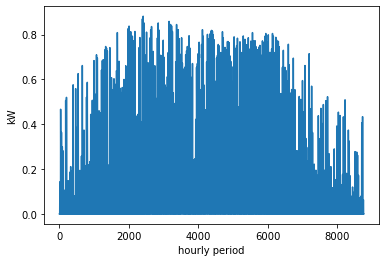

Annual Solar Generation: 1247.82 kWh


In [42]:
# import data
solar_profile = pd.read_csv("C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/ninja_pv_51.7415_-1.2495_corrected.csv", usecols=[1]).values

# plot data
plt.plot(solar_profile)  # just plotting a single day from the entire year
plt.ylabel("kW")
plt.xlabel("hourly period")
plt.show()

# calculate annual generation
print("Annual Solar Generation: {:.2f} kWh".format(solar_profile.sum()))
 


Create Electrolyzer Class and Location Class


In [20]:
class electrolyzer:
    def __init__(self,elec_price, production_rate,install_cost,max_power,min_power_percentage):
        self.elec_price = elec_price             #GBP Per MWh
        self.production_rate = production_rate   #kg of hydrogen produced per second per MW of electricity
        self.install_cost = install_cost         #in GBP
        self.max_power = max_power               #in MW
        self.min_power = max_power*min_power_percentage/100  # in MW, minimum power to retain its ability to ramp up and down quickly  
        
    
class location:
    def __init__(self, var_waterprice, fixed_waterprice):
        self.var_waterprice = var_waterprice
        self.fixed_waterprice = fixed_waterprice
        
class energysystem: 
    def __init__(self,location,electrolyzer):
        self.location = location
        self.electrolyzer = electrolyzer
    
  #  def CapEx(self): 
   #     CapEx = self.location.fixed_waterprice + self.electrolyzer.install_cost
    #    return CapEx 
        
    #def OpEx:   #water and electricity costs per kg of hydrogen 
        
    #    return OpEx

ITM HGas3SP Electrolyzer created below

In [36]:
itm_H3GSP = electrolyzer(160.3, 0.01/2.35, 3090000, 2.35,0.001)
Oxford = location(23,0.1)

Test1 = energysystem(Oxford,itm_H3GSP) 

Test1.location.var_waterprice

23

In [44]:
Power = solar_profile*0.001                   #Average power(MW) of solar grid in the hourly period


Theoretical Electrolyzer Power Output in each hour period <br>
(Taking into account max rate of change of power) <br>
(Without taking into account max and min power)

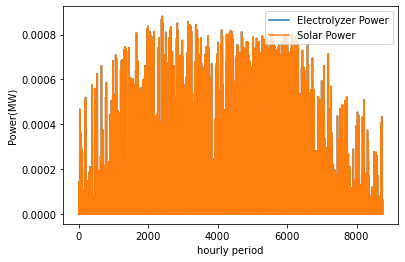

In [45]:
T = len(Power)                           # no. of hourly periods
grid_demand = np.zeros((T,1))            # power required from grid 
H_produced = np.zeros((T,1))             # kg of hydrogen produced in the hour period


# solar power change compared to  previous hour period
p_change = np.zeros((T,1))               
for j in range(T):
    if j == 0: 
        p_change[j] = 0
    else: 
        p_change[j] = Power[j] - Power[j-1]

# for this test, we will set max power change of electrolyzer to be 2e-4 MW per hour
max_p_change = 2

needed_p_change = np.zeros((T,1))            # power change needed for electrolyzer
electrolyzer_power = np.zeros((T,1))

for j in range(T):
    if j == 0:
        electrolyzer_power[j] = Power[j]
        needed_p_change[j] = 0
    else: 
        needed_p_change[j] = Power[j] - electrolyzer_power[j-1]
    
    if abs(needed_p_change[j]) > max_p_change:      #if electrolyzer cannot handle power change
        electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*max_p_change
        
    elif abs(needed_p_change[j]) <= max_p_change:   #if electrolyzer can handle power change
        if electrolyzer_power[j-1] == Power[j-1]:      # if electrolyzer is handling it well
            electrolyzer_power[j] = Power[j]
        elif electrolyzer_power[j-1] != Power[j-1]:     # if electrolyzer was not in sync with solar power 
            electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*min(abs(max_p_change),abs(needed_p_change[j]))
            
ax = plt.subplot(1,1,1)
plt.plot(electrolyzer_power, label = 'Electrolyzer Power')
plt.plot(Power, label = 'Solar Power')
plt.xlabel('hourly period')
plt.ylabel('Power(MW)')

ax.legend()


Hydrogen produced in each hourly period <br>
(Taking into account max and min power) <br>
Cost of electricity if electrolyzer takes electricity from grid <br>
Cost of water  <br>
CO2 emissions from grid electricity


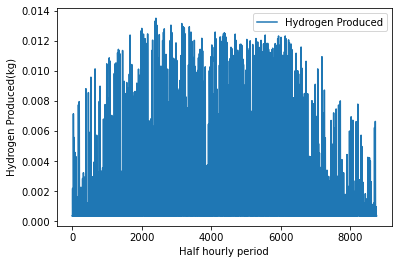

In [47]:
# electrolyzer takes electricity from grid, if solar power falls below min power 
# assume solar power is free 

# Records hydrogen produced in each hour period
for j in range(T):
    if electrolyzer_power[j] > itm_H3GSP.max_power:                      #if theoretical power exceeds max power
        H_produced[j] = itm_H3GSP.max_power*itm_H3GSP.production_rate*60*60 
    elif electrolyzer_power[j] >= itm_H3GSP.min_power:                          
        H_produced[j] = electrolyzer_power[j]*itm_H3GSP.production_rate*60*60
    else:                                                               #if theoretical power is below min power
        H_produced[j] = itm_H3GSP.min_power*itm_H3GSP.production_rate*60*60
        grid_demand[j] = itm_H3GSP.min_power - electrolyzer_power[j] 
        
Total_elec_cost =sum(grid_demand*itm_H3GSP.elec_price)


co2perelec = 0.1
co2_emissions = sum(grid_demand*co2perelec)

ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Hydrogen Produced')
plt.xlabel('Half hourly period')
plt.ylabel('Hydrogen Produced(kg)')

ax.legend()

Daily Hydrogen Production throughout the year 

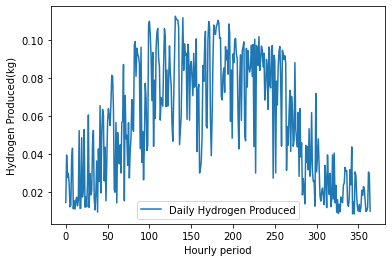

In [59]:
No_of_days = T/24
No_of_days = int(No_of_days)
daily_H2_pd = np.zeros((No_of_days,1))
for i in range(int(No_of_days)):
    daily_H2_pd[i] = sum(H_produced[(0 + i*24):(23 + i*24)])
    
ax = plt.subplot(1,1,1)
plt.plot(daily_H2_pd, label = 'Daily Hydrogen Produced')
plt.xlabel('Hourly period')
plt.ylabel('Hydrogen Produced(kg)')

ax.legend()

Reverse Engineer actual electrolyzer power 

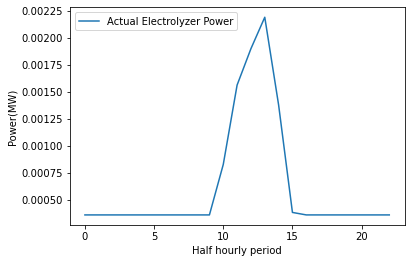

In [39]:
actual_electrolyzer_power = H_produced / itm_H3GSP.production_rate

ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Actual Electrolyzer Power')
plt.xlabel('Half hourly period')
plt.ylabel('Power(MW)')

ax.legend()

Code for Hydrogen Storage

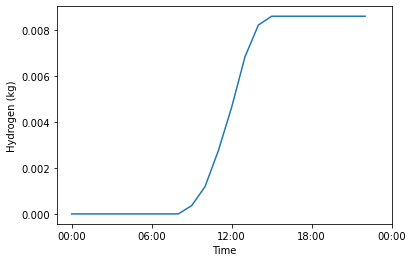

In [41]:
hydrogen_capacity = 10  # kg

T = len(solar_profile)                    # no. of half hour periods
outputi = np.zeros((T,1))  # hydrogen production flow
soc = np.zeros((T,1))  # weight of hydrogen stored


for j in range(T):
    if j == 0:
        socval = 0 
    else:
        socval = soc[j-1]                 #stores soc from the previous timeslot
    
    # if there is production of hydrogen
    if Power[j] > 0:      
        outputi[j] = H_produced[j]
        soc[j] = socval + outputi[j]     #battery is being discharged so soc decreases
        
    # if there is no production of hydrogen
    elif solar_profile[j] == 0: 
        soc[j] = socval                     # battery soc has no change

        
ax = plt.subplot(1,1,1)
p = plt.plot(soc)

plt.xticks([0,6,12,18,24])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
plt.ylabel('Hydrogen (kg)', color='k')
plt.xlabel('Time', color='k')
plt.show()